In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig
import re

In [ ]:
params_figura = {
        "figure.dpi":100,
        "figure.autolayout":True,
        "lines.linewidth":1
}

In [ ]:
def respuesta_impulso_filtro_iir(filtro_sos,N=1024,fs=2):
    N=int(N)
    t = np.arange(N)/fs
    h = sig.sosfilt(filtro_sos,(1,)+(0,)*(N-1))
    plt.stem(t,h)
def respuesta_escalon_filtro_iir(filtro_sos,N=1024,fs=2):
    N=int(N)
    t = np.arange(N)/fs
    h = sig.sosfilt(filtro_sos,(1,)*(N))
    plt.plot(t,h)
def plantilla_filtro(wp,ws,lmax_pass,lmin_stop,solo_fpos=True,fs=2,ymin=None,ymax=None):
    fmax=fs/2
    if ymin is None: ymin = -lmin_stop*2
    if ymax is None: ymax = -lmax_pass*.1
    y_paso = np.array([ymin,ymin,-lmax_pass,-lmax_pass])
    y_rechazo = np.array([-lmin_stop,-lmin_stop,ymax,ymax])
    color = "#0004"
    if np.isscalar(wp): # LP/HP
        if (wp>ws): # HP
            y_paso,y_rechazo = y_rechazo,y_paso
            wp,ws = ws,wp
        if solo_fpos:
            plt.fill([0,wp,wp,0],y_paso,color)
            plt.fill([ws,fmax,fmax,ws],y_rechazo,color)
        else:
            plt.fill([-wp,wp,wp,-wp], y_paso,color)
            plt.fill([ws,fmax,fmax,ws], y_rechazo,color)
            plt.fill([-fmax,-ws,-ws,-fmax], y_rechazo,color)
    else: #BP/BS
        if (wp[1]>ws[1]): #BS
            y_paso,y_rechazo = y_rechazo,y_paso
            wp,ws = ws,wp
        if solo_fpos:
            plt.fill([wp[0],wp[1],wp[1],wp[0]],y_paso,color)
            plt.fill([0,ws[0],ws[0],0],y_rechazo,color)
            plt.fill([ws[1],fmax,fmax,ws[1]],y_rechazo,color)
        else:
            plt.fill([wp[0],wp[1],wp[1],wp[0]],y_paso,color)
            plt.fill([-wp[1],-wp[0],-wp[0],-wp[1]],y_paso,color)
            plt.fill([-ws[0],ws[0],ws[0],-ws[0]],y_rechazo,color)
            plt.fill([ws[1],fmax,fmax,ws[1]],y_rechazo,color)
            plt.fill([-fmax,-ws[1],-ws[1],-fmax],y_rechazo,color)
def respuesta_frec_filtro_iir(filtro_sos,N=1024,solo_fpos=True,fs=2):
    N=int(N)
    h = sig.sosfilt(filtro_sos,(np.sqrt(fs*N),)+(0,)*(N-1))
    frecs,pxx=sig.periodogram(h,window="rect",return_onesided=False,detrend=False,scaling="density",fs=fs)
    if solo_fpos:
        pxx=pxx[frecs>=0]
        frecs =frecs[frecs>=0]
    else:
        frecs = np.fft.fftshift(frecs)
        pxx = np.fft.fftshift(pxx)
    pxx_db = 10*np.log10(pxx)
    p = plt.plot(frecs,pxx_db)
    plt.ylabel("Magnitud (dB)")
    plt.xlabel("Frecuencia (Fs=%1.3g Hz)"%fs)
    return p

def caracteristicas_filtro(filtro_sos,wp,ws,lmax_pass,lmin_stop,fs=2,fignum=None,solo_fpos=True):
    if np.isscalar(wp):
        caracteristica = 'pasa bajos' if wp<ws else 'pasa altos'
    else:
        caracteristica = 'pasa banda' if wp[1]<ws[1] else 'de rechazo de banda'
    with plt.rc_context(params_figura):
        plt.figure(fignum,figsize=(12,2*.6*12))
        plt.subplot(3,1,1)
        respuesta_frec_filtro_iir(filtro_sos,fs=fs,N=1024,solo_fpos=solo_fpos)
        plt.ylim(bottom=-2*lmin_stop)
        ymin,ymax = plt.ylim()
        plantilla_filtro(wp,ws,lmax_pass,lmin_stop,fs=fs,ymin=ymin,ymax=ymax,solo_fpos=solo_fpos)
        plt.grid(True)
        plt.title("Filtro IIR %s"%caracteristica)
        plt.subplot(3,1,2)
        respuesta_impulso_filtro_iir(filtro_sos,N=200,fs=fs)
        plt.title("Respuesta al impulso unitario")
        plt.subplot(3,1,3)
        respuesta_escalon_filtro_iir(filtro_sos,N=200,fs=fs)
        plt.title("Respuesta al escalón unitario")


In [ ]:
def fig1(wp,ws,lmax_pass,lmin_stop,fs=2,solo_fpos=True):
    if np.isscalar(wp):
        response = 'low' if wp<ws else 'high'
    else:
        response = 'bandpass' if wp[1]<ws[1] else 'bandstop'
    filtro_sos = sig.butter(*sig.buttord(wp,ws,lmax_pass,lmin_stop,fs=fs),response,output='sos',fs=fs)
    caracteristicas_filtro(filtro_sos,wp,ws,lmax_pass,lmin_stop,fs=fs,fignum=1,solo_fpos=solo_fpos)
fig1(.3,.5,3,60)
#fig1(.5,.3,3,60)
#fig1([.3,.4],[.1,.6],3,60)
#fig1([.1,.6],[.3,.4],3,60)

In [ ]:
def fig2(wp,ws,lmax_pass,lmin_stop):
    #Replicar fig 1 con un prototipo distinto
    pass

In [ ]:
def fig3():
    Nw=51
    Nfft=1024
    parametros = {
        'exponential':[[None,-(Nw-1)/np.log(.1)],[None,-(Nw-1)/np.log(.4)]],
        'chebwin':[[45],[60],[90]],
        'dpss':[[.3],[.5],[1]],
        'gaussian':[[10],[100],[256]],
        'general_cosine':[[[1,.5,.25]],[[1, 1.942604, 1.340318, 0.440811, 0.043097]]],
        'general_gaussian':[[0.5,100],[0.75,100],[1,100]],
        'general_hamming':[[.6],[.54],[.5],[.4]],
        'kaiser':[[0],[3],[5],[6],[8.6],[1]]

    }
    ventanas = list(filter(lambda x: re.match("^(_|get_|window)",x) is None ,dir(sig.windows)))
    with plt.rc_context(params_figura):
        nv=len(ventanas)
        plt.figure(3,figsize=(10,3*nv))
        for k in range(nv):
            v = ventanas[k]
            plt.subplot(nv,2,2*k+1)
            if v in parametros:
                hs = [np.pad(sig.get_window((v,*p),Nw,fftbins=True),Nw) for p in parametros[v]]
            else:
                hs = [np.pad(sig.get_window(v,Nw,fftbins=True),Nw)]
            ti = -len(hs[0])//2
            t = np.arange(ti,len(hs[0])+ti)
            for h in hs:
                plt.plot(t,h)
            plt.title("Ventana "+v)
            plt.subplot(nv,2,2*k+2)
            for h in hs:
                H = np.abs(np.fft.fftshift(np.fft.fft(h,Nfft)))
                H = H/H.max()
                H[H==0]=1e-10
                F = np.linspace(-0.5,0.5,len(H))
                H_db = 20*np.log10(H)
                plt.plot(F,H_db)
                plt.ylim(-120,1)

            plt.grid(True)
            plt.title("Respuesta en frecuencia")
fig3()

In [ ]:
def fig4():
    Nw=1024
    xs = np.arange(Nw)
    w_frac_1 = 2*np.pi/Nw*50.5
    w_frac_2 = 2*np.pi/Nw*51.5
    ys = (.5*np.sin(w_frac_1*xs)+.5*np.sin(w_frac_2*xs))
    parametros = {
        'exponential':[[None,-(Nw-1)/np.log(.1)],[None,-(Nw-1)/np.log(.4)]],
        'chebwin':[[45],[60],[90]],
        'dpss':[[.3],[.5],[1]],
        'gaussian':[[10],[100],[256]],
        'general_cosine':[[[1,.5,.25]],[[1, 1.942604, 1.340318, 0.440811, 0.043097]]],
        'general_gaussian':[[0.5,100],[0.75,100],[1,100]],
        'general_hamming':[[.6],[.54],[.5],[.4]],
        'kaiser':[[0],[3],[5],[6],[8.6],[1]]

    }
    ventanas = list(filter(lambda x: re.match("^(_|get_|window)",x) is None ,dir(sig.windows)))
    with plt.rc_context(params_figura):
        nv=len(ventanas)
        plt.figure(4,figsize=(10,3*nv))
        for k in range(nv):
            v = ventanas[k]
            plt.subplot(nv,2,2*k+1)
            if v in parametros:
                hs = [sig.get_window((v,*p),Nw,fftbins=False) for p in parametros[v]]
            else:
                hs = [sig.get_window(v,Nw,fftbins=False)]
            for h in hs:
                plt.plot(ys*h)
            plt.title("Ventana "+v)
            plt.subplot(nv,2,2*k+2)
            for h in hs:
                F,H=sig.periodogram(ys,window=h,detrend=False,return_onesided=True)
                H[H==0]=1e-20
                plt.plot(F,10*np.log10(H))
                plt.xlim(.02,0.08)
            plt.title("Periodograma")
fig4()

C:\Users\Fernando\AppData\Local\Temp\ipykernel_18696\973275908.py:25: RuntimeWarning: divide by zero encountered in log10
  H = np.fft.fftshift(20*np.log10(np.fft.fft(h[k],Nfft)))
C:\Users\Fernando\AppData\Local\Temp\ipykernel_18696\973275908.py:25: RuntimeWarning: invalid value encountered in multiply
  H = np.fft.fftshift(20*np.log10(np.fft.fft(h[k],Nfft)))
C:\Users\Fernando\AppData\Local\Temp\ipykernel_18696\973275908.py:25: RuntimeWarning: divide by zero encountered in log10
  H = np.fft.fftshift(20*np.log10(np.fft.fft(h[k],Nfft)))
C:\Users\Fernando\AppData\Local\Temp\ipykernel_18696\973275908.py:25: RuntimeWarning: invalid value encountered in multiply
  H = np.fft.fftshift(20*np.log10(np.fft.fft(h[k],Nfft)))


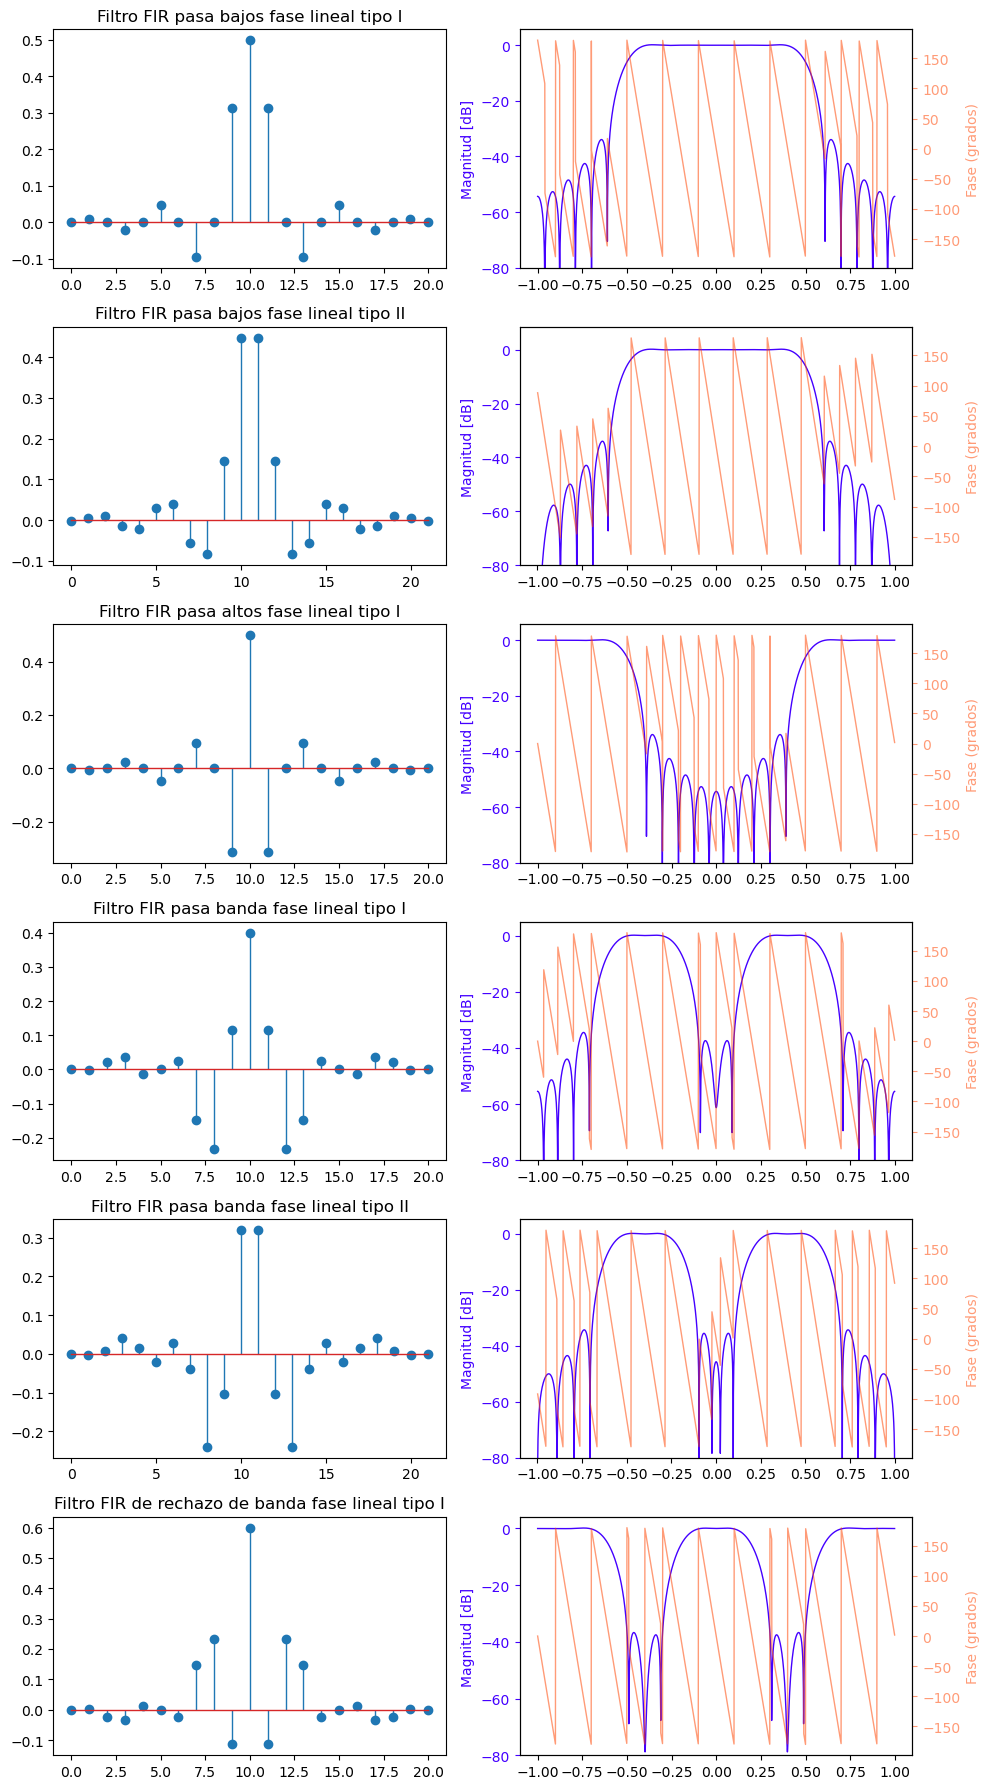

In [334]:
def fig5():

    titulos = ["Filtro FIR pasa bajos fase lineal tipo I",
               "Filtro FIR pasa bajos fase lineal tipo II",
               "Filtro FIR pasa altos fase lineal tipo I",
               "Filtro FIR pasa banda fase lineal tipo I",
               "Filtro FIR pasa banda fase lineal tipo II",
               "Filtro FIR de rechazo de banda fase lineal tipo I"]
    h = [sig.firwin(21,.5,window='cosine',pass_zero=True),
         sig.firwin(22,.5,window='cosine',pass_zero=True),
         sig.firwin(21,.5,window='cosine',pass_zero=False),
         sig.firwin(21,(.2,.6),window='cosine',pass_zero=False),
         sig.firwin(22,(.2,.6),window='cosine',pass_zero=False),
         sig.firwin(21,(.2,.6),window='cosine',pass_zero=True)]
    with plt.rc_context(params_figura):
        N=len(h)
        Nfft=2048
        plt.figure(5,figsize=(10,3*N))
        for k in range(N):
            plt.subplot(N,2,2*k+1)
            plt.stem(h[k])
            plt.title(titulos[k])
            ax1=plt.subplot(N,2,2*k+2)
            ax2=ax1.twinx()
            H = np.fft.fftshift(20*np.log10(np.fft.fft(h[k],Nfft)))
            fs = np.fft.fftshift(np.fft.fftfreq(Nfft,1/2))
            H_mag = np.real(H)
            H_fase = np.imag(H)*(180/np.imag(20*np.log10(-1+0j)))
            cs = ['#40F','#F408'] 
            ax1.plot(fs,H_mag,color=cs[0])
            ax1.set_ylabel("Magnitud [dB]",color=cs[0])
            ax1.set_ylim(bottom=-80)
            ax1.tick_params('y',colors=cs[0])
            ax2.plot(fs,H_fase,color=cs[1])
            ax2.set_ylabel("Fase (grados)",color=cs[1])
            ax2.tick_params('y',colors=cs[1])
    plt.show()
fig5()

In [346]:
180/np.imag(20*np.log10(-1+0j))*np.imag(20*np.log10(1))

0.0